In [1]:
3 + 4

7

In [4]:
import essentia

In [2]:
filename = '../mp3/punky.mp3'

In [3]:
modelName = 'msd-musicnn-1.pb'
input_layer = 'model/Placeholder'
output_layer = 'model/Sigmoid'
msd_labels = ['rock','pop','alternative','indie','electronic','female vocalists','dance','00s','alternative rock','jazz','beautiful','metal','chillout','male vocalists','classic rock','soul','indie rock','Mellow','electronica','80s','folk','90s','chill','instrumental','punk','oldies','blues','hard rock','ambient','acoustic','experimental','female vocalist','guitar','Hip-Hop','70s','party','country','easy listening','sexy','catchy','funk','electro','heavy metal','Progressive rock','60s','rnb','indie pop','sad','House','happy']

In [4]:
# analysis parameters
sampleRate = 16000
frameSize=512
hopSize=256

# mel bands parameters
numberBands=96
weighting='linear'
warpingFormula='slaneyMel'
normalize='unit_tri'

# model parameters
patchSize = 187

In [5]:
import sys
sys.path


['/mnt/c/Users/grg_k/Synesthesia/essentia_models',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/georgekolasa/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/georgekolasa/.local/lib/python3.8/site-packages/IPython/extensions',
 '/home/georgekolasa/.ipython']

In [6]:
sys.path.insert(0, "/usr/local/lib/python3/dist-packages")
sys.path


['/usr/local/lib/python3/dist-packages',
 '/mnt/c/Users/grg_k/Synesthesia/essentia_models',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/georgekolasa/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/georgekolasa/.local/lib/python3.8/site-packages/IPython/extensions',
 '/home/georgekolasa/.ipython']

In [7]:
from essentia.streaming import *
from essentia import Pool, run


2021-07-16 16:05:29.973125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# pip install matplotlib

In [9]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec


In [11]:
# Algorithms for mel-spectrogram computation
audio = MonoLoader(filename=filename, sampleRate=sampleRate)

fc = FrameCutter(frameSize=frameSize, hopSize=hopSize)

w = Windowing(normalized=False)

spec = Spectrum()

mel = MelBands(numberBands=numberBands, sampleRate=sampleRate,
               highFrequencyBound=sampleRate // 2, 
               inputSize=frameSize // 2 + 1,
               weighting=weighting, normalize=normalize,
               warpingFormula=warpingFormula)

# Algorithms for logarithmic compression of mel-spectrograms
shift = UnaryOperator(shift=1, scale=10000)

comp = UnaryOperator(type='log10')

# This algorithm cuts the mel-spectrograms into patches
# according to the model's input size and stores them in a data
# type compatible with TensorFlow
vtt = VectorRealToTensor(shape=[1, 1, patchSize, numberBands])

# Auxiliar algorithm to store tensors into pools
ttp = TensorToPool(namespace=input_layer)

# The core TensorFlow wrapper algorithm operates on pools
# to accept a variable number of inputs and outputs
tfp = TensorflowPredict(graphFilename=modelName,
                        inputs=[input_layer],
                        outputs=[output_layer])

# Algorithms to retrieve the predictions from the wrapper
ptt = PoolToTensor(namespace=output_layer)

ttv = TensorToVectorReal()

# Another pool to store output predictions
pool = Pool()

In [13]:
audio.audio    >>  fc.signal
fc.frame       >>  w.frame
w.frame        >>  spec.frame
spec.spectrum  >>  mel.spectrum
mel.bands      >>  shift.array
shift.array    >>  comp.array
comp.array     >>  vtt.frame
vtt.tensor     >>  ttp.tensor
ttp.pool       >>  tfp.poolIn
tfp.poolOut    >>  ptt.pool
ptt.tensor     >>  ttv.tensor
ttv.frame      >>  (pool, output_layer)

# Store mel-spectrograms to reuse them later in this tutorial
comp.array     >>  (pool, "melbands")

In [14]:
from time import time

start_time = time()

run(audio)

print('Prediction time: {:.2f}s'.format(time() - start_time))

Prediction time: 2.13s


[   INFO   ] On connection UnaryOperator::array → VectorRealToTensor::frame:
[   INFO   ] BUFFER SIZE MISMATCH: max=0 - asked for read size 187
[   INFO   ] resizing buffer to 1640/205
2021-07-16 16:09:42.632592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3701000000 Hz
[ WARNING  ] VectorRealToTensor: Last patch produced by repeating the last 2 frames. May result in unreliable predictions.


In [15]:
import numpy as np

print('Most predominant tags:')
for i, l  in enumerate(np.mean(pool[output_layer],
                       axis=0).argsort()[-3:][::-1], 1):
    print('{}: {}'.format(i, msd_labels[l]))

Most predominant tags:
1: rock
2: indie
3: alternative


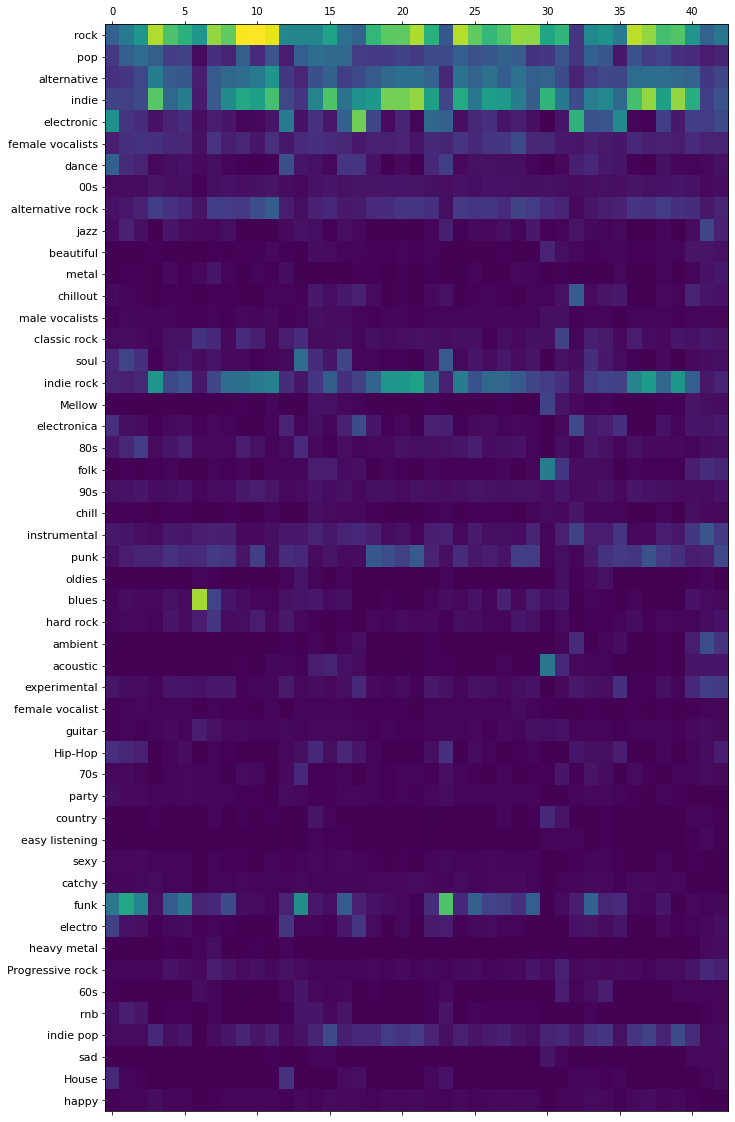

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 20]

f, ax = plt.subplots()
ax.matshow(pool[output_layer].T, aspect=1.5)
_ = plt.yticks(np.arange(50), msd_labels, fontsize=11)

NameError: name 'taggram' is not defined

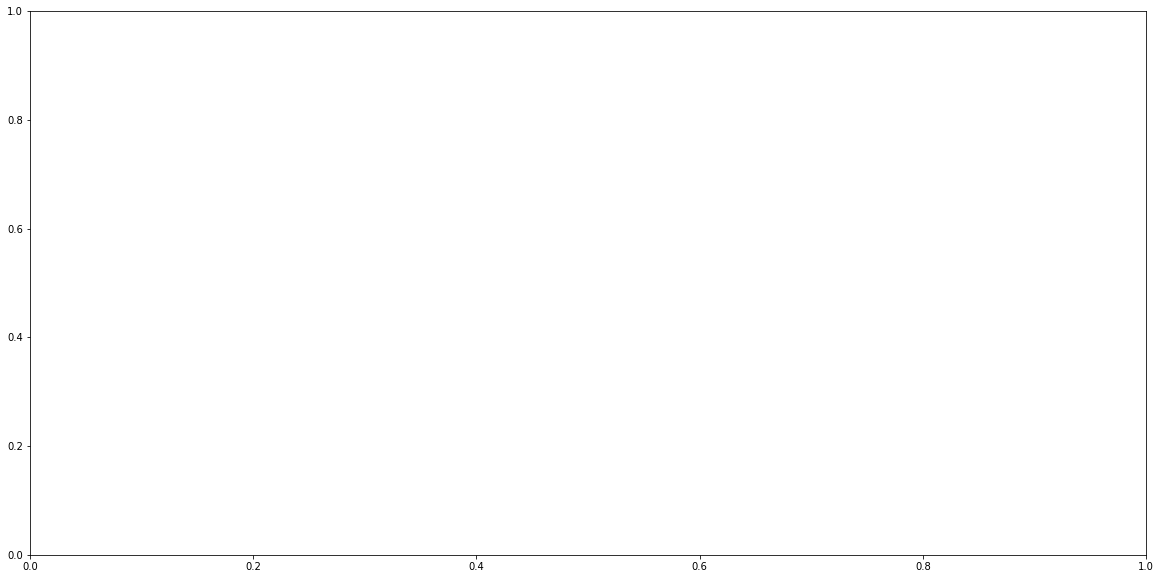

In [12]:

in_length = 3 # seconds -- by default, the model takes inputs of 3 seconds with no overlap

# depict taggram
plt.rcParams["figure.figsize"] = (20,10)
fontsize=12
fig, ax = plt.subplots()
ax.imshow(taggram.T, interpolation=None, aspect="auto")

# title
ax.title.set_text('Taggram')
ax.title.set_fontsize(fontsize)

# x-axis title
ax.set_xlabel('(seconds)', fontsize=fontsize)

# y-axis
y_pos = np.arange(len(tags))
ax.set_yticks(y_pos)
ax.set_yticklabels(tags, fontsize=fontsize-1)

# x-axis
x_pos = np.arange(taggram.shape[0])
x_label = np.arange(in_length/2, in_length*taggram.shape[0], 3)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, fontsize=fontsize)

plt.show()

In [12]:
from musicnn.tagger import top_tags
top_tags(filename, model='MSD_musicnn', topN=1)

Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. 

/home/drew/.local/lib/python3.6/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


done!
[../mp3/punky.mp3] Top1 tags: 
 - indie


['indie']

# Natural Language Processing

In [214]:
import speech_recognition as sr

In [215]:
r = sr.Recognizer()

In [216]:
with sr.AudioFile(filename) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    r.adjust_for_ambient_noise(source, duration = 3)
    text = r.recognize_google(audio_data)
    print(text)

UnknownValueError: 

## Large Audio Files

In [227]:
import speech_recognition as sr 
import os 
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [228]:
r = sr.Recognizer()

In [229]:
def get_large_audio_transcription(path):
    """
    Splitting the large audio file into chunks
    and apply speech recognition on each of these chunks
    """
    # open the audio file using pydub
    sound = AudioSegment.from_wav(path)  
    # split audio sound where silence is 700 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
        # experiment with this value for your target audio file
        min_silence_len = 500,
        # adjust this per requirement
        silence_thresh = sound.dBFS-14,
        # keep the silence for 1 second, adjustable as well
        keep_silence=500,
    )
    folder_name = "audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    whole_text = ""
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # try converting it to text
            try:
                text = r.recognize_google(audio_listened)
            except sr.UnknownValueError as e:
                print("Error:", str(e))
            else:
                text = f"{text.capitalize()}. "
                print(chunk_filename, ":", text)
                whole_text += text
    # return the text for all chunks detected
    return whole_text

In [232]:
nlpTextOutput = get_large_audio_transcription(filename)
print(nlpTextOutputt)

In [233]:
print(nlpTextOutput)

In [128]:
import speech_recognition as sr

recognize = sr.Recognizer()

audioFile = filename

with sr.AudioFile(audioFile) as source:
    print("Start talking: ")
    audio = recognize.record(source)
    print("Stop talking.")

try:
    text = recognize.recognize_google(audio, key=None, language='en-US', show_all=True)
    print("in the try block")
    print (text)
except Exception as e:
    print("I am here")
    print (e)

Start talking: 
Stop talking.
in the try block
[]
